# Assignment 4

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

The third part of this assignment will require you to use camera intrinsics to estimate the bounding box of a car.

---
### 4.1 Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [11]:
import cv2 as cv
import os

import numpy as np
import tqdm.auto as tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

In [1]:
%matplotlib tk

image_points_recorded = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q1/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points_recorded.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

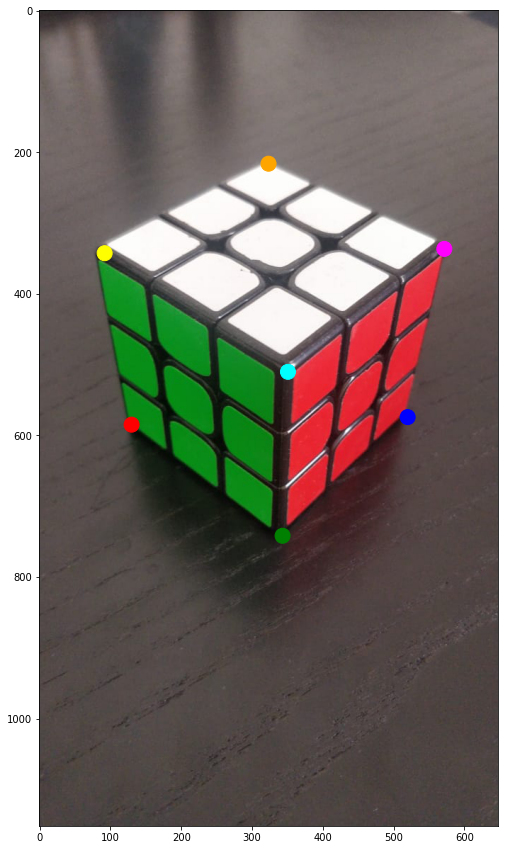

In [2]:
%matplotlib inline
N = len(image_points_recorded)
image_points = np.array(image_points_recorded)
fig = plt.figure(figsize=(10,15))

img = mpimg.imread('q1/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange']
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [3]:
x_world = np.array([
    [0, 1, 0],
    [0, 0, 0],
    [1, 0, 0],
    [0, 1, 1],
    [0, 0, 1],
    [1, 0, 1],
    [1, 1, 1],
])

x_image = image_points

print(x_image.shape, x_world.shape)

(7, 2) (7, 3)


Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


### DLT Formulation

Direct Linear Trasnsform (DLT) helps estimate the camera calibration matrix for any camera, using a 3D object with identifyable points in it's 2D image on the camera

It takes in a set of sample 3D world points $\mathbf{X}$ and the corresponding projected image point $\mathbf{x}$ on the camera frame. The matrix P is the interconvertor between those two.

$$\begin{bmatrix}x \\ y \\ 1 \\ \end{bmatrix} = P \begin{bmatrix} X \\ Y \\ Z \\ 1 \\ \end{bmatrix}$$

Flattening the matrix of unknowns, which is P, and expaning out equations in terms of the known values which are the points on the image and in the world, we are able to derive the following relations:
$$
x = \frac{p_{11}X + p_{12}Y + p_{13}Z + p_{14}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}
y = \frac{p_{21}X + p_{22}Y + p_{23}Z + p_{24}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}
$$

We have 2 equation of the form above for each of the $n$ points, giving us a total of $2n$ equations. Since there are 12 unknowns in the P matrix, we need atleast 6 points of known correspondence.

The collected system of linear equations bears the following form:
$$
\begin{bmatrix}
    -X_i & -Y_i & -Z_i & -1 & 0 & 0 & 0 & 0 & x_i X_i & x_i Y_i & x_i Z_i & x_i \\
    0 & 0 & 0 & 0 & -X_i & -Y_i & -Z_i & -1 & y_i X_i & y_i Y_i & y_i Z_i & y_i
\end{bmatrix}
\begin{bmatrix}p_{11} \\ p_{12} \\ \vdots \\ p_{43} \\ \end{bmatrix} = 0
$$

Since we will usually have more than 6 points, in the real world this equation is not perfectly solvable, we use approximations that minimizes the residuals.

The approach we take for this is that since we **cannot compute the true null space of A, we take instead of the null-vector the smallest eigen-valued eigen-vector of A, which is the best vector to minimize the residuals**. We reshape this matrix and enforce that the resultant matrix is rank deficient by dropping an eigenvalue from it's decomposition again, since this was an approximation.

With this process, we manage to come up with a very good approximation for the target transform.

In [4]:
def direct_linear_transform(x_image, x_world):
    """Returns the projection matrix of the camera using DLT
    It estimates both intrinsic and extrinsic properties of the world.
    :type x_image: np.ndarray
    :param x_image: Vector of points on the image, shape (n, 2)
    :type x_world: np.ndarray
    :param x_world: Vector of corresponding points in the world, shape (n, 3)
    :rtype: np.ndarray
    :returns: The projection matrix of shape (3, 4)
    """
    
    # Converting to homogeneous coordinates
    x_image = np.concatenate([x_image, np.ones(shape=(len(x_image), 1))], axis=1)
    x_world = np.concatenate([x_world, np.ones(shape=(len(x_world), 1))], axis=1)

    # Generating the 2n equations in 12 parameters
    num_points = x_image.shape[0]
    a_x = np.stack([
        -x_world[:, 0],
        -x_world[:, 1],
        -x_world[:, 2],
        np.full(num_points, fill_value=-1), 
        np.zeros(num_points),
        np.zeros(num_points),
        np.zeros(num_points),
        np.zeros(num_points),
        x_image[:, 0] * x_world[:, 0],
        x_image[:, 0] * x_world[:, 1],
        x_image[:, 0] * x_world[:, 2],
        x_image[:, 0]
    ], axis=1)
    a_y = np.stack([
        np.zeros(num_points),
        np.zeros(num_points),
        np.zeros(num_points),
        np.zeros(num_points),
        -x_world[:, 0], 
        -x_world[:, 1], 
        -x_world[:, 2],
        np.full(num_points, fill_value=-1), 
        x_image[:, 1] * x_world[:, 0],
        x_image[:, 1] * x_world[:, 1],
        x_image[:, 1] * x_world[:, 2],
        x_image[:, 1]
    ], axis=1)
    
    # Interleave to get the x's and y's together for easy reshaping later
    m = np.zeros(shape=(2 * num_points, a_x.shape[1]))
    for i in range(num_points):
        m[2 * i + 0] = a_x[i]
        m[2 * i + 1] = a_y[i]
    
    # Use the SVD formuation to solve for best solution to overdetermined set
    u, d, v = np.linalg.svd(m)
    projection_mat = v[-1, :].reshape((3, 4))
    return projection_mat


p = direct_linear_transform(x_image, x_world)
print(p)

[[ 2.70178041e-01 -2.04294567e-01 -6.74777129e-02  3.57788483e-01]
 [-8.69636895e-02 -9.37292942e-02 -3.60355634e-01  7.78778838e-01]
 [ 1.57546122e-04  1.22634755e-04 -2.25658594e-04  1.04886204e-03]]


### Theory

- Explain how DLT is implemented and show why it works (proof)
- When does DLT fail?

## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [5]:
#Get reprojected points
def get_points(p, x_world):
    # Converting to homogeneous coordinates
    x_world = np.concatenate([x_world, np.ones(shape=(len(x_world), 1))], axis=1)
    # Doing the actual matrix multiplication
    x_image = p @ x_world.T
    # Normalizing and removing the homogeneous coordinate
    x_image = x_image / x_image[2]
    x_image = x_image[:2]
    # Return the generated points
    return x_image.T

#Get reprojection error
def get_err(x_image, x_world, p):
    x_image_reprojected = get_points(p, x_world)
    print(x_image_reprojected)
    error = np.mean(np.linalg.norm(x_image_reprojected - x_image, axis=1) ** 2)
    return error

error = get_err(x_image, x_world, p)
print("Reprojection error:", error)

[[131.02376037 584.76433237]
 [341.12063184 742.49882768]
 [520.52575679 573.45031945]
 [ 90.94177259 343.28694654]
 [352.65980739 508.28650397]
 [571.49024222 337.96549438]
 [322.81974157 215.45549808]]
Reprojection error: 2.6006302437040913


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [6]:
def ret_RKT(p):
    # Estimate translation
    h_inv = np.linalg.pinv(p[:, :3])
    t = - h_inv @ p[:, -1]
    # Estimate rotation
    r_tr, k_inv = np.linalg.qr(h_inv)
    r = r_tr.T
    # Estimate fundamental matrix
    k = np.linalg.pinv(k_inv)
    k = k / k[-1, -1]
    # Return the results
    return r, k, t

r, k, t = ret_RKT(p)

#### Verifying the R, K, T Values

Use `np.isclose` to verify the matrix

In [7]:
transform = np.concatenate([r, np.expand_dims(t, axis=1)], axis=1)
np.isclose(k @ transform, p, atol=1e4)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

**Reproject the world points with P matrix you have obtained via DLT and visualize**

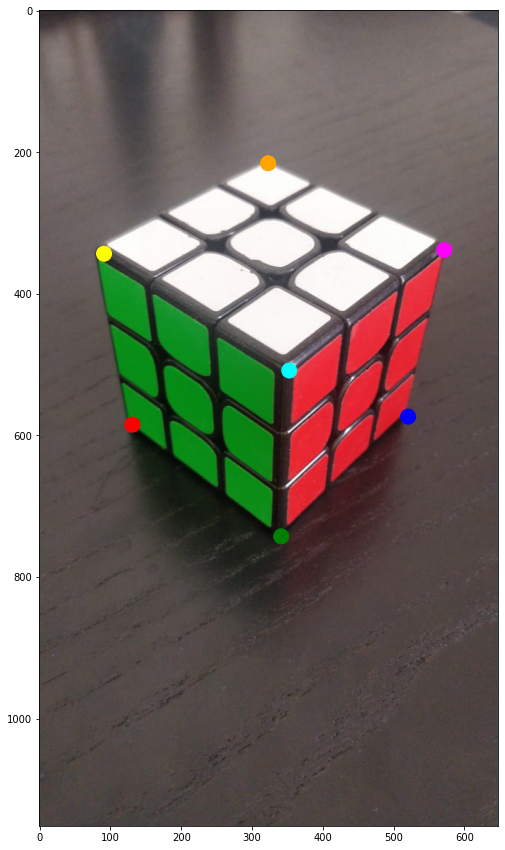

In [8]:
x_reprojected = get_points(p, x_world)

N = len(x_reprojected)
fig = plt.figure(figsize=(10,15))

img = mpimg.imread('q1/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange']
area = (15 * np.ones(N))**2 

plt.scatter(x_reprojected[:,0], x_reprojected[:,1], c=colors, s=area)
plt.show()

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in `q1/zhangs` folder for this task. Familiarize yourself with the different parameters for this method.

**Reference**: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

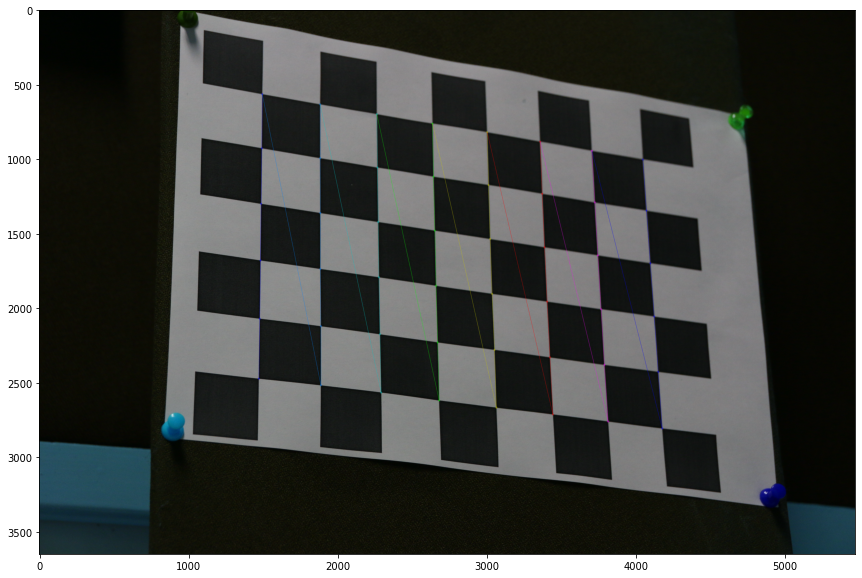

In [10]:
# Termination Criterion
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

obj = np.zeros(shape=(6 * 8, 3))
obj[:, :2] = np.mgrid[0:6, 0:8].T.reshape(-1,2)

obj_points, img_points = [], [] 
plt.figure(figsize=(20,10))

for img_name in tqdm.tqdm(sorted(os.listdir('q1/Zhangs/'))):    
    image = cv.imread(os.path.join('q1/Zhangs/', img_name))
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    ret, corners = cv.findChessboardCorners(image_gray, (6, 8))
    corners = cv.cornerSubPix(image_gray, corners, winSize=(11, 11), zeroZone=(-1, -1), criteria=criteria)
    obj_points.append(obj)
    img_points.append(corners)

    image = cv.drawChessboardCorners(image, (6, 8), corners, True)
    plt.imshow(image)

---
### 4.2 Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. You should first estimate the fundamental matrix from these two images.

<img src="./q2/img1.jpg" alt="image 1" width="400"/>
<img src="./q2/img2.jpg" alt="image 2" width="400"/>


Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. For this question you will need to compute the F matrix on your own without using inbuilt functions. 

In [12]:
image_1 = plt.imread('q2/img1.jpg')
image_2 = plt.imread('q2/img2.jpg')

We use the Sift matcher from OpenCV to compute the matching keypoints. For this we have followed the following tutorial: https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/

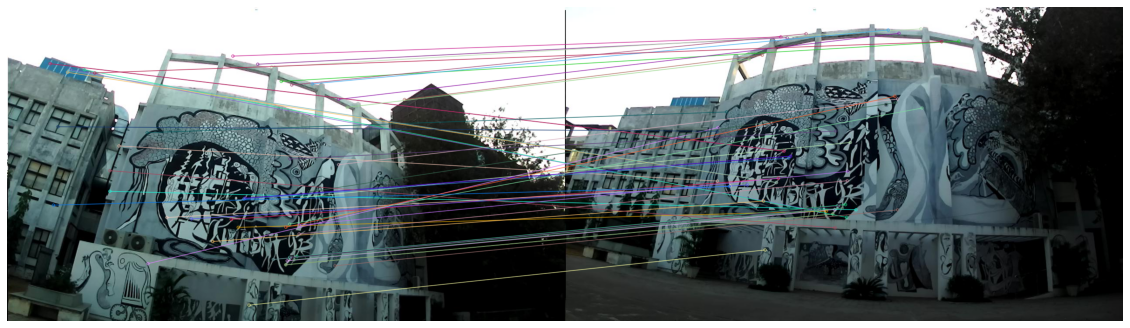

In [14]:
sift = cv.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(cv.cvtColor(image_1, cv.COLOR_BGR2GRAY), None)
keypoints_2, descriptors_2 = sift.detectAndCompute(cv.cvtColor(image_2, cv.COLOR_BGR2GRAY), None)

bf_matcher = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
matches = bf_matcher.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

image_matching = cv.drawMatches(image_1, keypoints_1, image_2, keypoints_2, matches[:50], image_2, flags=2)

plt.figure(figsize=(20, 6))
plt.axis('off')
plt.imshow(image_matching)
plt.show()

In [15]:
x_image_1 = np.array([keypoints_1[match.queryIdx].pt for match in matches])
x_image_2 = np.array([keypoints_2[match.trainIdx].pt for match in matches])

### Estimating the Fundamental Matrix

The following is the process to estimate the fundamental matrix of the camera using only the corresponding points information. This algorithm is also called the 8-point algorithm.

Following Cyrill Stachnis video was referred to for implementing the algorithm: https://www.youtube.com/watch?v=zX5NeY-GTO0

* **Step 1:** We compute the pointwise correspondences, and using the fact that all the in the other image should fall on the epipolar line, use use the facts that the epipolar line is $F x = 0$, so the points should follow $x^{\prime T} F x = 0$.
* **Step 2:** We treat the values in $F$ as the unknowns and since $x$ and $x^\prime$ are both known, we can formualate a set of linear homogenous equations, we use np.kron to compute the coefficient vector for the same.
* **Step 3:** To solve this overdetermined system of equations, we perform the SVD of the input and take the smallest eigenvector of the coefficient matrix to minimize the residual. We reshape this into a 3x3 matrix to form the initial guess of our fundamental matrix.
* **Step 4:** The fundamental matrix needs to be rank deficient, but what if it's not. We compute the SVD again, drop the smallest eigen value, and put everything back together to form our final rank-deficient F matrix.

Finally, we add a quick test to ensure that the residuals are actually small given our F matrix, which they are.

In [16]:
x_image_1_hom = np.concatenate([x_image_2, np.ones(shape=(len(x_image_1), 1))], axis=1)
x_image_2_hom = np.concatenate([x_image_1, np.ones(shape=(len(x_image_2), 1))], axis=1)

mat = np.stack([np.kron(x_image_1_hom[i], x_image_2_hom[i]) for i in range(len(x_image_1_hom))], axis=0)
u, d, v = np.linalg.svd(mat)
f = np.reshape(v[-1], (3, 3))

u, d, v = np.linalg.svd(f)
d[-1] = 0
f = u @ np.diag(d) @ v
f /= f[-1, -1]

print(f)
print(np.sqrt(np.mean([
    (x_image_1_hom[i, None] @ f @ x_image_2_hom[i, None].T) ** 2
    for i in range(len(x_image_1))
])))

[[ 4.53151781e-07  1.29692389e-06 -8.28114528e-04]
 [ 1.00898643e-06  2.19399851e-06 -1.65315554e-03]
 [-5.72100086e-04 -1.47190044e-03  1.00000000e+00]]
0.07854248378086227


We plot the estimated point correspondences.

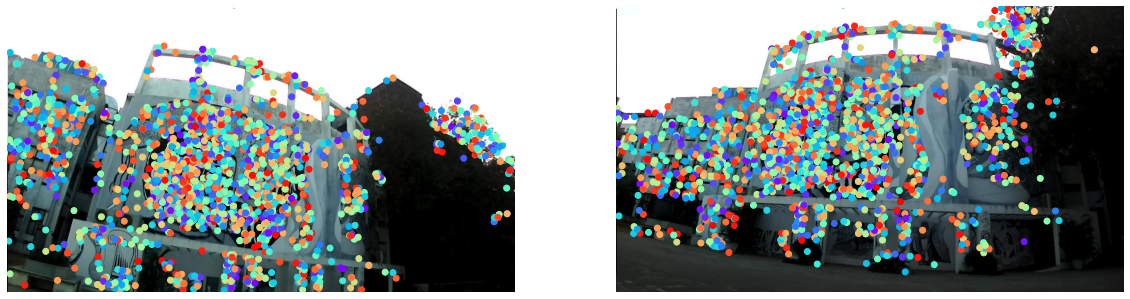

In [17]:
plt.figure(figsize=(20, 10))
colors = [np.random.randint(1, 255) for _i in range(max(len(x_image_1), len(x_image_2)))]
plt.subplot(121)
plt.axis('off')
plt.imshow(image_1)
plt.scatter(x_image_1[:,0], x_image_1[:,1], c=colors, cmap='rainbow')
plt.subplot(122)
plt.axis('off')
plt.imshow(image_2)
plt.scatter(x_image_2[:,0], x_image_2[:,1], c=colors, cmap='rainbow')
plt.show()

### Plotting the Epipolar Lines

The epipolar lines are simple to derive, they are the lines joining the projection center of the camera to the point of interest, for each point in image 2, the corresponding point in image 1 will lie on it's epipolar line.

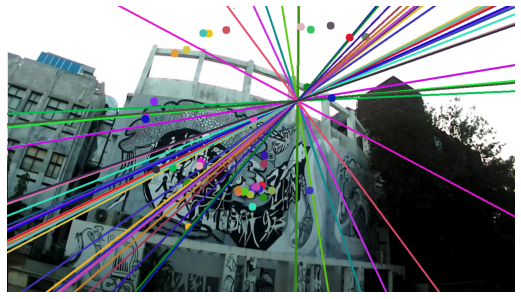

In [18]:
def epipolar_lines(image_1, x_image_1, x_image_2, f):
    for i in range(min(x_image_1.shape[0], 50)):
        a, b, c = f @ np.array([x_image_1[i][0], x_image_1[i][1], 1])
        color = [np.random.randint(1, 255) for _ in range(3)]
        image_1 = cv.line(
            image_1, 
            (0, int(-c / b)), 
            (image_1.shape[1], int(-(c + a * image_1.shape[1]) / b)), 
            color, 
            4
        ) 
        image_1 = cv.circle(
            image_1, 
            (int(x_image_2[i][0]), int(x_image_2[i][1])), 
            10, 
            color, 
            -1
        )
    return image_1

image_epipolar_lines = epipolar_lines(np.copy(image_1), x_image_1, x_image_2, f)

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.axis('off')
plt.imshow(image_epipolar_lines)
plt.show()

**Provide a clear explanation on your approach for both this task and the next**

#### Task 2
Report the location of the epipoles. Mathematically find the epipoles and verify that the lines intersect at the epipole.

In [19]:
u, d, v = np.linalg.svd(f.T)
epipole_1 = (v[-1] / v[-1, -1])[:-1]
u, d, v = np.linalg.svd(f)
epipole_2 = (v[-1] / v[-1, -1])[:-1]
print(f.T @ np.array([epipole_1[0], epipole_1[1], 1]))
print(f"Epipole in image 1 is at {epipole_1}, and that in image 2 is at {epipole_2}")

[ 4.45607093e-17  5.35595873e-17 -6.12843110e-14]
Epipole in image 1 is at [731.44709076 238.50026732], and that in image 2 is at [1040.62353262  274.92293456]


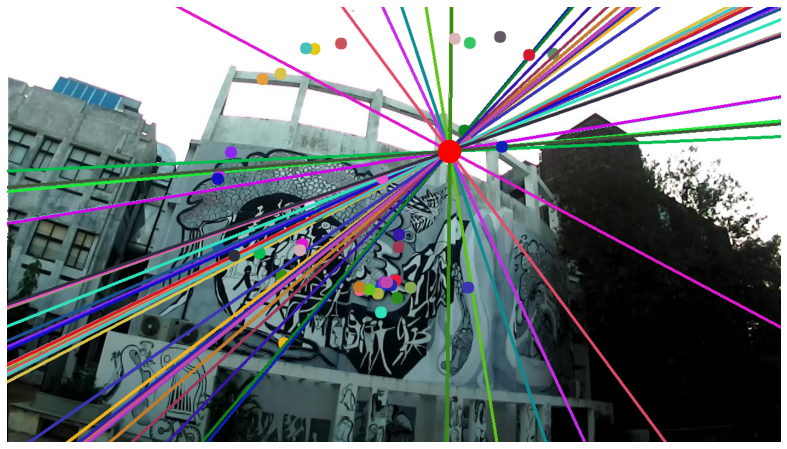

In [20]:
plt.figure(figsize=(15, 8))
plt.axis('off')
plt.imshow(image_epipolar_lines)
plt.scatter(epipole_1[0], epipole_1[1], color='red', s=500)
plt.show()

So visually we see that all the epipolar lines intersect at the epipole. The mathematical proof for this is trivial, since the epipolar line is defined by the following equation:
$$x^T_{1 \times 3} F_{3 \times 3} x^{pt}_{3 \times 1} = 0$$

Where $x^{pt}$ is the point for which we are finding the epipolar point and $x$ is the vector of the point, which if it satisfies the equation, is a part of the line. This equation is satisfied if the vector $x$ belongs to the nullspace of F. Since we ensures that the smallest eigenvalue of $F$ is 0, the corresponding vector is in the null space of F.

In [21]:
epipole_1_hom = np.array([epipole_1[0], epipole_1[1], 1])

assert np.allclose(f.T @ epipole_1_hom, 0), "Epipole is not in the fundamental matrix's null space"

for image_point in x_image_1:
    a, b, c = f @ np.array([image_point[0], image_point[1], 1])
    assert np.isclose(a * epipole_1[0] + b * epipole_1[1] + c, 0), "Epipole is not on Epipolar line"

So we have also verified the intersection of all epipolar lines at the computed epipole numerically, so our computations are all correct.

____
### 4.3 Drawing a bounding box around a car and localizing it in the camera frame
You’ve been provided with an image, also taken from a self-driving car, that shows another car in front. The camera has been placed on top of the car, 1.65 m from the ground, and assume the image plane is perfectly perpendicular to the ground. K is provided to you. Your task is to draw a 3D-bounding box around the car in front as shown. Your approach should be to place eight points in the 3D world such that they surround all the corners of the car, then project them onto the image, and connect the projected image points using lines. You might have to apply a small 5° rotation about the vertical axis to align the box perfectly. Rough dimensions of the car - h: 1.38 m, w: 1.51, l: 4.10. (Hint: Fix a point on the ground as your world origin.). Also estimate the approximate translation vector to the mid-point of the two rear wheels of the car in the camera frame.

![Kitti car](./q3/image.png)

[[721.53   0.   609.55]
 [  0.   721.53 172.85]
 [  0.     0.     1.  ]]


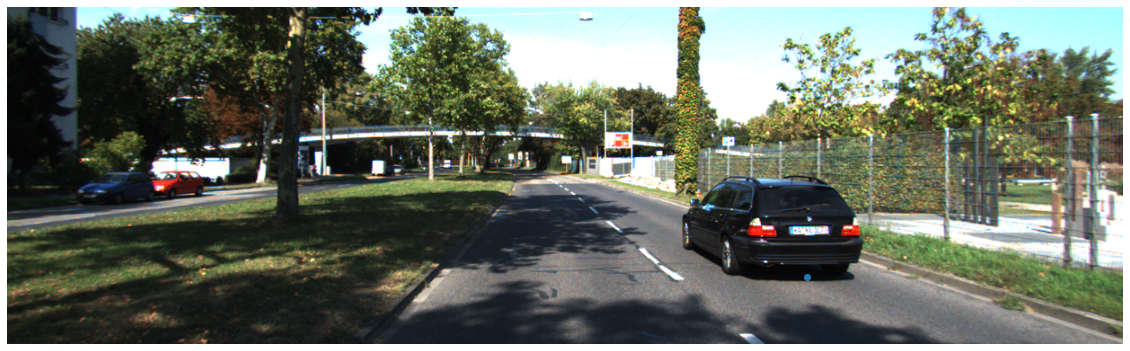

In [22]:
import os

image = plt.imread('q3/image.png')
text = open('q3/K.txt', 'r').read()
k = np.array(list(map(lambda x: list(map(float, x.split(','))), text.strip()[5:-1].split(';'))))

plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(image)

origin = np.array([890, 300])

plt.scatter([origin[0]], [origin[1]])
print(k)

Given that we have chosen a point at the middle of the car on the back bottom face as the origin, we can use it to estimate the translation vector of the camera to the car. We know the camera intrinsics from the given K vector, and we will assume for figuring out the translation that there is no rotation, and we also know the height of our camera from the ground, so we have only two variables to solve for.

$$\begin{bmatrix}\lambda x \\ \lambda y \\ \lambda \end{bmatrix} = K \cdot \begin{bmatrix}1 & 0 & 0 & -\delta x \\ 0 & 1 & 0 & -h \\ 0 & 0 & 1 & -\delta z \end{bmatrix}\begin{bmatrix} 0 \\ 0 \\ 0 \\ 1 \end{bmatrix}$$

So now we know that we
$$\begin{bmatrix}\lambda x \\ \lambda y \\ \lambda \end{bmatrix} = -\begin{bmatrix}K_{11} \delta x + K_{12} h + K_{13} \delta z \\ K_{21} \delta x + K_{22} h + K_{23} \delta z \\ K_{31} \delta x + K_{32} h + K_{33} \delta z\end{bmatrix}$$

Therefore we can solve for the two unknowns in this projective equations:

Following is the equation to solve for x:
$$\frac{K_{11} \delta x + K_{12} h + K_{13} \delta z}{K_{31} \delta x + K_{32} h + K_{33} \delta z} = x$$
Following is the equation to solve for y:
$$\frac{K_{21} \delta x + K_{22} h + K_{23} \delta z}{K_{31} \delta x + K_{32} h + K_{33} \delta z} = y$$

We can collect the coefficients:
$$(K_{11} - x K_{31}) \delta x + (K_{12} - x K_{32}) h + (K_{13} - x K_{33}) \delta z = 0$$
$$(K_{21} - y K_{31}) \delta x + (K_{22} - y K_{32}) h + (K_{23} - y K_{33}) \delta z = 0$$


Now we multiply to cancel out the coefficients:

$$(K_{11} - x K_{31}) (K_{23} - y K_{33}) \delta x + (K_{12} - x K_{32}) (K_{23} - y K_{33}) h = (K_{13} - x K_{33}) (K_{21} - y K_{31}) \delta x + (K_{13} - x K_{33}) (K_{22} - y K_{32}) h$$

$$(K_{12} - x K_{32}) (K_{21} - y K_{31}) h + (K_{13} - x K_{33}) (K_{21} - y K_{31}) \delta z = (K_{11} - x K_{31}) (K_{22} - y K_{32}) h + (K_{11} - x K_{31}) (K_{23} - y K_{33}) \delta z$$


And finally solving these equations, we get:

$$\delta x = \frac{(K_{13} - x K_{33}) (K_{22} - y K_{32}) - (K_{12} - x K_{32}) (K_{23} - y K_{33})}{(K_{11} - x K_{31}) (K_{23} - y K_{33}) - (K_{13} - x K_{33}) (K_{21} - y K_{31})} h$$

$$\delta z = \frac{(K_{11} - x K_{31}) (K_{22} - y K_{32}) - (K_{12} - x K_{32}) (K_{21} - y K_{31})}{(K_{13} - x K_{33}) (K_{21} - y K_{31}) - (K_{11} - x K_{31}) (K_{23} - y K_{33})} h$$

In [33]:
h = 1.38
w = 1.51
l = 4.10

# In the ground grame of the front car
points = np.array([
    [-w/2, 0, 0],
    [-w/2, -h, 0],
    [ w/2, 0, 0],
    [-w/2, 0, -l],
    [ w/2, 0, -l],
    [-w/2, -h, -l],
    [ w/2, -h, 0],
    [ w/2, -h, -l],
])
edges = [(i, j) for i in range(len(points)) for j in range(i + 1, len(points)) 
         if np.sum(np.isclose(points[i] - points[j], 0)) == 1]
print(f"Our cube has a total of {len(edges)} edges.\n")

# Estimate the translation vector assuming no rotation

h = 1.65
ox, oy = origin

dx = (
    ((k[0, 2] - ox * k[2, 2]) * (k[1, 1] - oy * k[2, 1]) - (k[0, 1] - ox * k[2, 1]) * (k[1, 2] - oy * k[2, 2])) / 
    ((k[0, 0] - ox * k[2, 0]) * (k[1, 2] - oy * k[2, 2]) - (k[0, 2] - ox * k[2, 2]) * (k[1, 0] - oy * k[2, 0]))
) * h
dz = (
    ((k[0, 0] - ox * k[2, 0]) * (k[1, 1] - oy * k[2, 1]) - (k[0, 1] - ox * k[2, 1]) * (k[1, 0] - oy * k[2, 0])) / 
    ((k[0, 2] - ox * k[2, 2]) * (k[1, 0] - oy * k[2, 0]) - (k[0, 0] - ox * k[2, 0]) * (k[1, 2] - oy * k[2, 2]))
) * h

# Compute the total projection vector

r = np.eye(3)
t = np.array([[dx], [h], [dz]])
print(f"Computed Translation Vector: [{t[0]}, {t[1]}, {t[2]}]\n")

p = k @ np.concatenate([r, t], axis=1)
p = p / p[-1, -1]
print(f"Computed Projection Matrix:\n{p}")

Our cube has a total of 12 edges.

Computed Translation Vector: [[3.6393433], [1.65], [9.36314982]]

Computed Projection Matrix:
[[7.70606061e+01 0.00000000e+00 6.51009555e+01 8.90000000e+02]
 [0.00000000e+00 7.70606061e+01 1.84606680e+01 3.00000000e+02]
 [0.00000000e+00 0.00000000e+00 1.06801666e-01 1.00000000e+00]]


Now that we have our entire camera projection vector, we can just take our 3D points and project them onto the image. And next, we can push other stuff

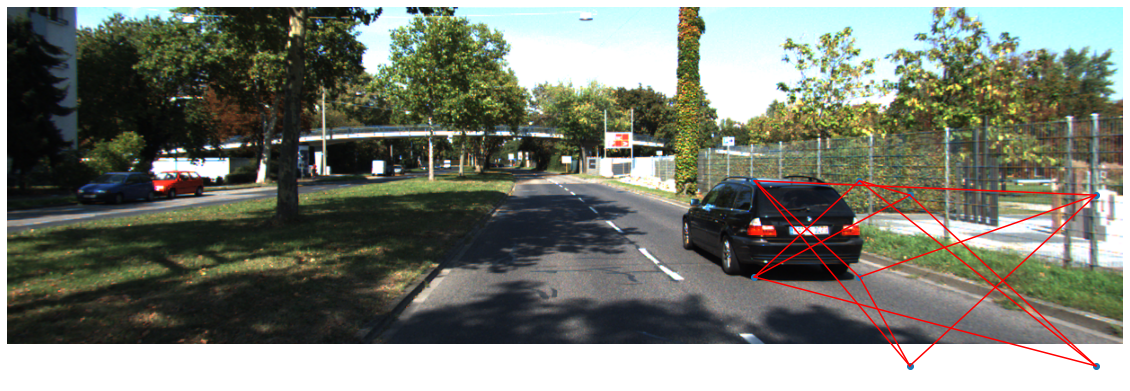

[[ 831  300]
 [ 831  193]
 [ 948  300]
 [1004  399]
 [1211  399]
 [1004  209]
 [ 948  193]
 [1211  209]]


In [34]:
# Project onto the image
points_hom = np.concatenate([points, np.ones(shape=(len(points), 1))], axis=1)

pixels_hom = (p @ points_hom.T)
pixels_hom /= pixels_hom[2, :]
pixels = pixels_hom.T.astype(int)[:, :2]

plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(image)
plt.scatter(pixels[:, 0], pixels[:, 1])
for edge in edges:
    plt.plot([pixels[edge[0], 0], pixels[edge[1], 0]], [pixels[edge[0], 1], pixels[edge[1], 1]], 'r')
plt.show()

print(pixels)

There seems to be some minor shuffling of coordinates here, will fix in the late-day submission.